In [39]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import ast
from scipy.stats import pointbiserialr
from collections import Counter
from pySankey.sankey import sankey
os.chdir("./../..")
print(os.getcwd())

/Users/adamouazzani/Documents


In [2]:
df_paths = pd.read_csv('data/output/processed_data/paths_processed.csv', low_memory=False)

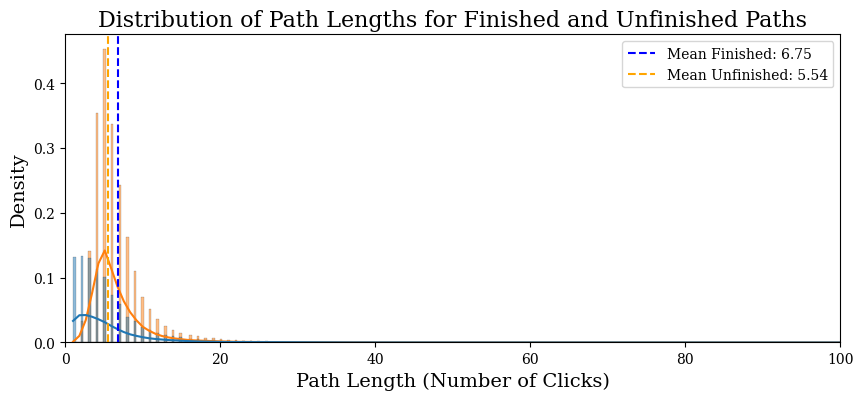

Mann-Whitney U test results for Finished vs. Unfinished Path Lengths:
U-statistic = 772343915.0, p-value = 0.0


In [24]:
###################################
# Plotting the Distribution of Path Lengths
###################################

# Separate the data into finished and unfinished paths
finished_paths = df_paths[df_paths['finished'] == True]  # Paths that are finished
unfinished_paths = df_paths[df_paths['finished'] == False]  # Paths that are unfinished

# Create a histogram to visualize the distribution of path lengths (number of clicks)
plt.figure(figsize=(10, 4))  # Set the figure size
sns.histplot(df_paths, x='n_click', hue='finished', kde=True, bins=500, stat="density")

# Add vertical lines at the mean path lengths for finished and unfinished paths
mean_finished = finished_paths['n_click'].mean()  # Calculate mean for finished paths
mean_unfinished = unfinished_paths['n_click'].mean()  # Calculate mean for unfinished paths
plt.axvline(mean_finished, color='blue', linestyle='--', label=f'Mean Finished: {mean_finished:.2f}')
plt.axvline(mean_unfinished, color='orange', linestyle='--', label=f'Mean Unfinished: {mean_unfinished:.2f}')

# Add a title and labels to the plot
plt.title('Distribution of Path Lengths for Finished and Unfinished Paths', fontsize=16)
plt.xlabel('Path Length (Number of Clicks)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim(0, 100)  # Limit the x-axis to show path lengths between 0 and 100
plt.legend()  # Show the legend to indicate the colors for finished and unfinished paths
plt.show()

###################################
# Mann-Whitney U Test: Comparing Path Lengths Between Finished and Unfinished Paths
###################################

# Extract the path lengths for finished and unfinished paths
finished_lengths = df_paths[df_paths['finished'] == True]['n_click']  # Path lengths for finished paths
unfinished_lengths = df_paths[df_paths['finished'] == False]['n_click']  # Path lengths for unfinished paths

# Perform the Mann-Whitney U test to compare the two distributions
u_stat, p_value = stats.mannwhitneyu(finished_lengths, unfinished_lengths)

# Print the results of the test
print(f"Mann-Whitney U test results for Finished vs. Unfinished Path Lengths:")
print(f"U-statistic = {u_stat}, p-value = {p_value}")


In [25]:
###################################
# Step 1: Identify the last 4 unique combinations based on group size
###################################

# Group the data by 'source_link' and 'target_link' and count the occurrences.
# Then, we sort by the group sizes and select the last 4 combinations.
last_4_combinations = df_paths.groupby(by=["source_link", "target_link"]).size().sort_values().tail(4).index

# Step 2: Filter the DataFrame to include only the last 4 combinations
# We filter the original DataFrame to include only rows matching these last 4 combinations.
df_last_4_cases = df_paths[df_paths.set_index(["source_link", "target_link"]).index.isin(last_4_combinations)]

###################################
# Step 3: Group by the last 4 combinations and 'finished' status, then calculate the mean of 'n_clicks'
###################################

# Group the filtered DataFrame by 'source_link', 'target_link', and 'finished', and calculate the mean of 'n_click' for each group.
df_grouped = df_last_4_cases.groupby(["source_link", "target_link", "finished"])["n_click"].mean().unstack()

###################################
# Step 4: Calculate the mean difference and perform t-test
###################################

# Initialize a list to store the results for each (source, target) combination
results = []

# Loop through each of the last 4 combinations
for (source, target) in last_4_combinations:
    # Filter the data for the current (source, target) combination
    data = df_last_4_cases[(df_last_4_cases["source_link"] == source) & (df_last_4_cases["target_link"] == target)]
    
    # Separate the 'n_click' values for finished and unfinished paths
    finished_clicks = data[data["finished"] == True]["n_click"]
    unfinished_clicks = data[data["finished"] == False]["n_click"]
    
    # Perform a t-test to compare the means of 'n_click' for finished vs. unfinished paths
    t_stat, p_value = stats.ttest_ind(finished_clicks, unfinished_clicks, equal_var=False)
    
    # Calculate the mean difference between finished and unfinished path lengths
    mean_diff = finished_clicks.mean() - unfinished_clicks.mean()
    
    # Store the results in the 'results' list
    results.append({
        "source_link": source,
        "target_link": target,
        "mean_diff": mean_diff,
        "t_stat": t_stat,
        "p_value": p_value
    })

###################################
# Step 5: Convert results into a DataFrame
###################################

# Convert the list of results into a DataFrame for easier interpretation
df_results = pd.DataFrame(results)

# Step 6: Display the results
print(df_results)

  source_link target_link  mean_diff     t_stat       p_value
0     Pyramid        Bean   2.679587  11.532746  1.605381e-29
1     Theatre       Zebra   2.740315  14.538996  3.410645e-45
2    Asteroid      Viking   2.478926  13.851010  1.600135e-40
3       Brain   Telephone   2.896909  18.759760  2.702263e-72


# Time per path

In [5]:
df_paths.duration.describe()

count    74114.000000
mean       336.397793
std        574.935531
min          1.000000
25%         63.000000
50%        121.000000
75%        244.000000
max       4973.000000
Name: duration, dtype: float64

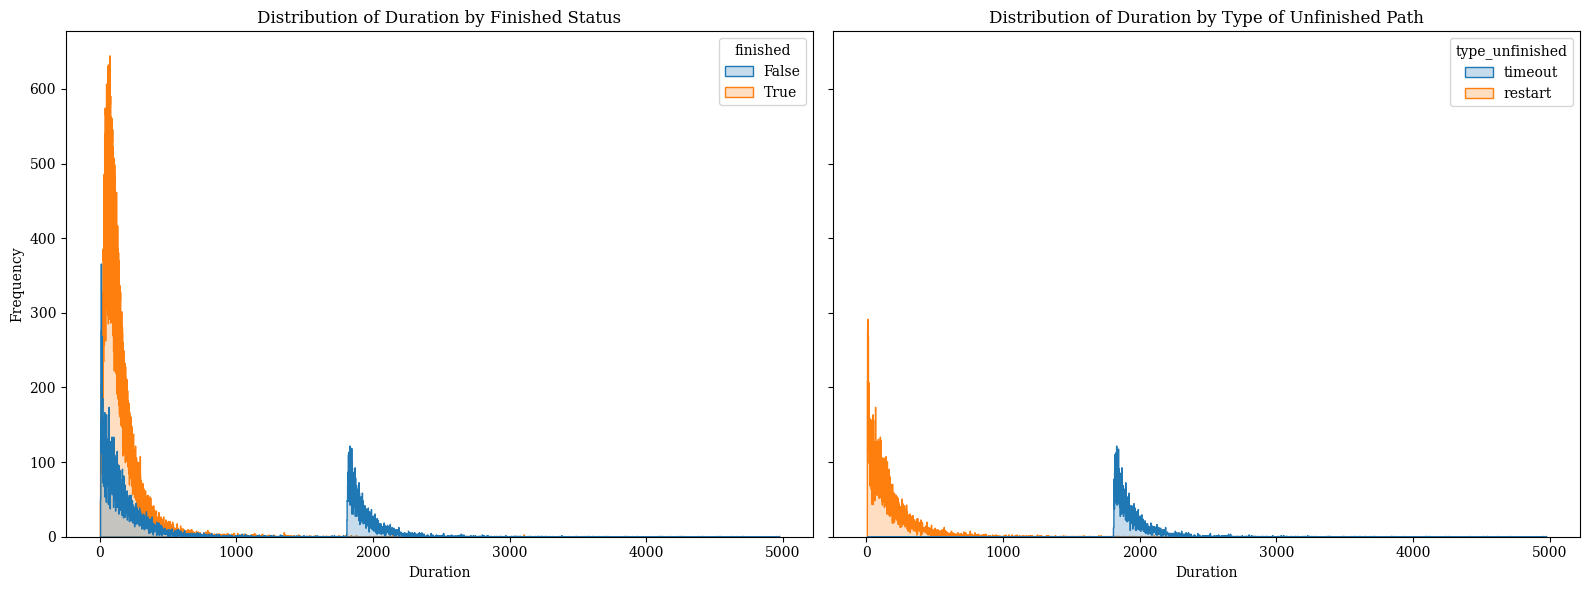

In [26]:
# Define the number of bins for the histogram
n_bins = 3000

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the first histogram: Duration by Finished Status
sns.histplot(data=df_paths, x="duration", hue="finished", bins=n_bins, element="step", ax=axes[0])
axes[0].set_title("Distribution of Duration by Finished Status")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Filter data for unfinished paths only
df_paths_unfinished = df_paths[df_paths["finished"] == False]

# Plot the second histogram: Duration by Type of Unfinished Path
sns.histplot(data=df_paths_unfinished, x="duration", hue="type_unfinished", bins=n_bins, element="step", ax=axes[1])
axes[1].set_title("Distribution of Duration by Type of Unfinished Path")
axes[1].set_xlabel("Duration")

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


### Conclusion
We cannot conclude that unfinished paths indicate higher cognitive load based solely on time spent, as the increased mean duration in these cases is largely due to session timeouts. In these instances, players were not necessarily experiencing difficulty; rather, they abandoned the session, allowing time to accumulate passively. As a result, the prolonged durations in unfinished paths reflect a lapse in activity rather than active engagement or cognitive load. Thus, any assumptions about cognitive load based on these time differences would be unreliable.

# Cognitive shift per link

Moving from one category of knowledge to another (e.g., from science-related articles to arts-related articles) requires cognitive shifting, which can increase cognitive load. Cognitive shifting is known to engage the executive function of the brain and may lead to errors or abandonment if the shift is too taxing

In [27]:
df_cat = pd.read_csv("data/output/processed_data/categories_processed.csv")
df_cat = df_cat[["article_name", "article_category_1"]]
article_to_category = dict(zip(df_cat["article_name"], df_cat["article_category_1"]))



In [28]:
def map_articles_to_categories(article_list):
    # Convert the string representation of the list into an actual list
    article_list = ast.literal_eval(article_list)
    
    list_cat = []  # Initialize an empty list to store categories for each article
    
    # Iterate through each article in the list
    for article in article_list:
        # For each article, map it to its corresponding category using the 'article_to_category' dictionary
        # If the article is not found, return "Unknown" as the category
        list_cat.append(article_to_category.get(article, "Unknown"))
    
    return list_cat  # Return the list of categories


In [29]:
# Create a new colum with path category

# Step 1: Create a dictionary to map article names to categories
article_to_category = dict(zip(df_cat["article_name"], df_cat["article_category_1"]))

# Step 2: Apply the function to each element in 'resolved_path_list_name' and create a new column
df_paths["resolved_path_list_category"] = df_paths["resolved_path_list_name"].apply(map_articles_to_categories)


In [30]:
# Create shift metric

def count_category_changes(category_list):
    if not category_list:  # Check if the list is empty
        return 0
    change_count = 0
    for i in range(1, len(category_list)):
        if category_list[i] != category_list[i - 1]:  # Check for a change
            change_count += 1
    return change_count

# Apply the function to each row in the DataFrame
df_paths["category_change_count"] = df_paths["resolved_path_list_category"].apply(count_category_changes)

In [31]:
print(df_paths["category_change_count"].describe())

# remove outliers
df_paths = df_paths[df_paths["category_change_count"] <= 100]

print(df_paths["category_change_count"].describe())


count    74113.000000
mean         3.171441
std          3.008430
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max         73.000000
Name: category_change_count, dtype: float64
count    74113.000000
mean         3.171441
std          3.008430
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max         73.000000
Name: category_change_count, dtype: float64


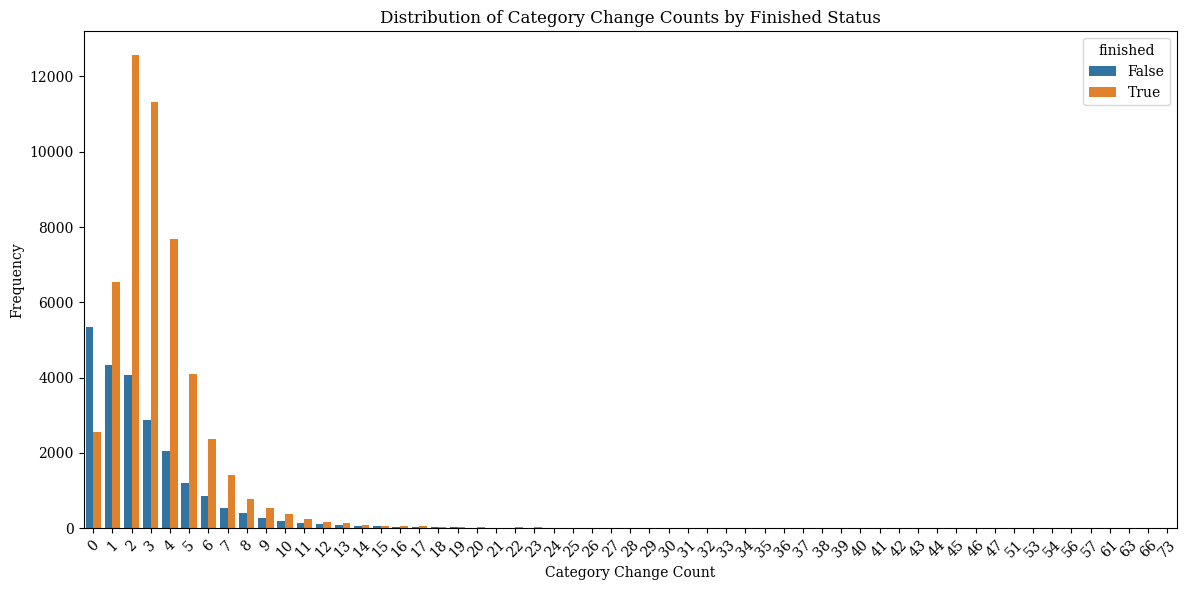

In [35]:
# Step 1: Ensure category change counts are computed
df_paths["category_change_count"] = df_paths["resolved_path_list_category"].apply(count_category_changes)

# Step 2: Aggregate the data
# Group by 'finished' and 'category_change_count' to count occurrences
agg_data = df_paths.groupby(['finished', 'category_change_count']).size().reset_index(name='count')

# Step 3: Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_data, x='category_change_count', y='count', hue='finished')#, palette={True: "green", False: "red"})

# Step 4: Customize the plot
plt.title("Distribution of Category Change Counts by Finished Status")
plt.xlabel("Category Change Count")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

In [37]:
# Separate the data into finished and not finished paths
finished_counts = df_paths[df_paths["finished"] == True]["category_change_count"]
not_finished_counts = df_paths[df_paths["finished"] == False]["category_change_count"]

# Perform Welch's t-test (which does not assume equal variances)
t_stat, p_value = stats.ttest_ind(finished_counts, not_finished_counts, equal_var=False)

# Set the significance level (alpha)
alpha = 0.05

# Display the results of the t-test
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpret the p-value to determine whether to reject or fail to reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups.")


T-statistic: 23.506
P-value: 0.000
Reject the null hypothesis: There is a significant difference between the means of the two groups.


### Conclusion

Unexpectedly, the significant shift per link is higher in finished paths, which challenges our initial assumption that a higher shift would correlate with increased cognitive load and greater difficulty. This finding suggests that the relationship between cognitive load and task completion is more complex than anticipated. (Pepito is totally wrong).

To explore this behavior further, we should conduct a connectivity analysis. By examining the connections between different elements of the paths, we can gain insights into how the structure and flow of information influence both cognitive load and task success. Understanding these dynamics will help clarify the reasons behind the observed shifts in finished versus unfinished paths.

# Sankey Diagram

In [36]:
# Only for finished paths
df_paths_finished = df_paths[df_paths["finished"] == True]

data = df_paths_finished["resolved_path_list_category"]

df = pd.DataFrame(data)

# Extract source (first) and target (last) elements
df['source'] = df['resolved_path_list_category'].apply(lambda x: x[0])
df['target'] = df['resolved_path_list_category'].apply(lambda x: x[-1])

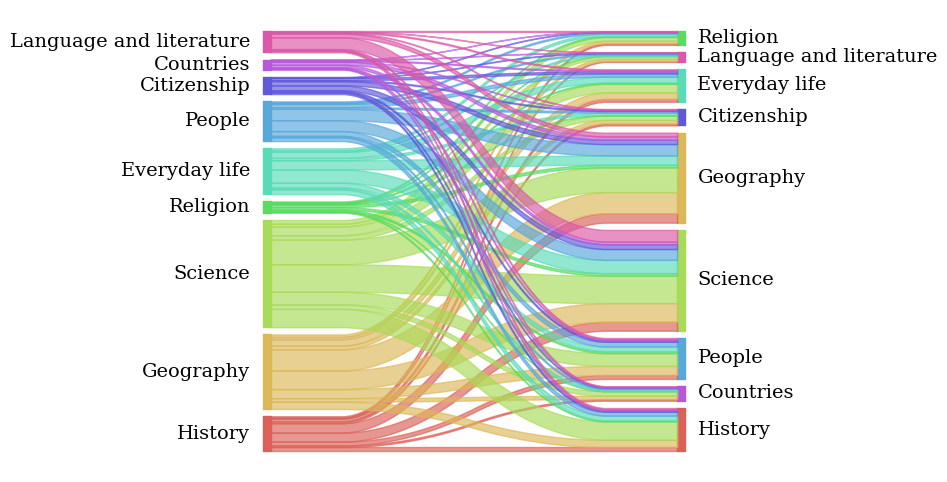

In [38]:
# Define the categories that we want to keep in the analysis
cat_to_use = [
    "History", "Geography", "Science", "Religion", "Everyday life",
    "Design and technology", "People", "Countries", "Language and literature", "Citizenship"
]

# Filter the DataFrame to only include rows where both the source and target belong to the specified categories
df = df[(df["source"].isin(cat_to_use)) & (df["target"].isin(cat_to_use))]

# Create a Sankey diagram using the filtered data
# This visualizes the flow between source and target categories
sankey(df["source"], df["target"], aspect=20)
